# Exploration_13

## 1. QA model

### 1.1 Module

- 사용할 패키지를 설치합니다.

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 7.5 MB/s 


In [3]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8270 sha256=df33d704d9ce2e66f9d9ba5be5fd57e59a59f7059426c41ca898dc7384aa8fc1
  Stored in directory: /root/.cache/pip/wheels/5d/1f/40/3fe78c6f4dd6f0522c558077283361e7d50fd7720d2f8fcd7e
Successfully built keras-rectified-adam


In [4]:
!pip install adamp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5998 sha256=6ce5ba9b00871ed6d12c52701e4980adeb7c2c65579e220508c343930cb58a6f
  Stored in directory: /root/.cache/pip/wheels/bb/95/21/ced2d2cb9944e3a72e58fece7958973eed3fd8d0aeb6e2e450
Successfully built adamp


In [5]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 7.2 MB/s 
     |████████████████████████████████| 453 kB 80.5 MB/s 


In [6]:
!pip install wordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from keras_radam import RAdam
from adamp import AdamP

import os
import re
import cv2
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from google.colab import drive
from google.colab.patches import cv2_imshow

In [8]:
random_seed = 1124
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### 1.2 Function

#### 1.2.1 print_json_tree

- list의 첫번째 item을 출력하도록 기능하는 함수입니다.

In [9]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

#### 1.2.2 _is_whitespace

- 받은 문장에서 띄어쓰기를 찾아냅니다.

In [10]:
def _is_whitespace(c):
    if c == ' ' or c == '\t' or c == '\r' or c == '\n' or ord(c) == 0x202F:
        return True
    return False

#### 1.2.3 _tokenize_whitespace

- string을 받아 띄어쓰기 단위로 정리해줍니다.  
자세한 내용은 data 전처리 과정을 통해 확인합니다.

In [11]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

#### 1.2.4 _tokenize_vocab

- subword 형태로 vocab을 생성하기 위한 함수입니다.  

In [12]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

#### 1.2.5 _improve_span

- context에서 answer의 위치를 토큰화된 상태에서 찾는 함수입니다.  

In [13]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

#### 1.2.6 dump_korquad

- dump_korquad는 전처리 과정을 수행합니다.  
 1) 데이터셋에서 _tokenize_whitespace로 context_words, char_to_word를 생성하고,  
 2) subword 단위로 vocab을 만들기 위해 생성한 _tokenize_vocab을 사용합니다.  
 3) _improve_span을 통해 context에서의 answer의 위치를 찾을 수 있게 전처리합니다.  
 4) .write을 사용해 파일로 저장합니다.

In [14]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

#### 1.2.7 utility function

- pad mask를 계산하거나, json 파일을 config로 사용하기 위한 함수들로 구성되어 있습니다.

In [15]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

#### 1.2.8 load_data

- 생성한 데이터셋 파일을 메모리에 로딩합니다.

In [16]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

#### 1.2.9 do_predict

- 학습된 모델을 통해 결과 예측을 위한 함수입니다. 

In [17]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

### 1.3 Data

#### 1.3.1 Data Load

- 구글 드라이브를 마운트합니다.

In [18]:
drive.mount('/gdrive')

Mounted at /gdrive


In [19]:
data_dir = '/gdrive/My Drive/Colab Notebooks/QA/data'
model_dir = '/gdrive/My Drive/Colab Notebooks/QA/models'

- 위에서 만든 print_json_tree로 훈련할 데이터 파일의 첫번째 item을 살펴봅니다.

In [20]:
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


- 바그너의 이야기가 들어있습니다.

- 이번에는 검증할 데이터의 첫번째 item을 살펴봅니다.

In [21]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


- json.dump로 훈련 데이터를 뜯어봅니다.

In [22]:
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

- 보면 아시겠지만, 구조는 
data 안에 paragraphs, title이 있고,  
paragraphs 안에 qas, context,  
qas 안에 answers, id, question,  
answers 안에 text, answer_start가 들어 있습니다.

#### 1.3.2 Preprocessing

##### 1) White Space

- 우선 왜 띄어쓰기 단위로 정보를 관리하는지 알아야할 필요가 있습니다.  
- 질문에 맞는 답이 단어가 될 수 있고, 문장이 될 수 있습니다. "1839년 파우스트를 읽었다", "1839년", "파우스트" 등... 그래서 한 문단의 내용을 word token 단위로 바꿔서 정답이 시작 단어와 끝나는 단어의 인덱스를 사용해 답을 꺼내는 방법을 사용합니다.

- whitespace 처리를 확인합니다.  
A 는 '나는'과 '네가' 사이의 whitespace가 1칸이고,  
B 는 '나는'과 '네가' 사이의 whitespace가 2칸입니다.

In [23]:
A = '나는 네가 지난 여름에 한 일을 알고 있다.'
B = '나는  네가 지난 여름에 한 일을 알고 있다.'

- 띄어쓰기 하나

In [24]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(A)
for c, i in zip(list(A), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'나' : 0
'는' : 0
' ' : 0
'네' : 1
'가' : 1
' ' : 1
'지' : 2
'난' : 2
' ' : 2
'여' : 3
'름' : 3
'에' : 3
' ' : 3
'한' : 4
' ' : 4
'일' : 5
'을' : 5
' ' : 5
'알' : 6
'고' : 6
' ' : 6
'있' : 7
'다' : 7
'.' : 7


(['나는', '네가', '지난', '여름에', '한', '일을', '알고', '있다.'],
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7])

- 띄어쓰기 둘

In [25]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(B)
for c, i in zip(list(B), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'나' : 0
'는' : 0
' ' : 0
' ' : 0
'네' : 1
'가' : 1
' ' : 1
'지' : 2
'난' : 2
' ' : 2
'여' : 3
'름' : 3
'에' : 3
' ' : 3
'한' : 4
' ' : 4
'일' : 5
'을' : 5
' ' : 5
'알' : 6
'고' : 6
' ' : 6
'있' : 7
'다' : 7
'.' : 7


(['나는', '네가', '지난', '여름에', '한', '일을', '알고', '있다.'],
 [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7])

- 띄어쓰기에 따라 인덱스 길이가 달라집니다. 띄어쓰기 단위로 token을 정리하고,  
영역에 맞춰 표시해주는 작업을 합니다.

##### 2) Vocab

- Sentence Piece 모델을 이용해 전처리를 진행합니다. 

In [26]:
vocab = spm.SentencePieceProcessor()
vocab.load(f'{model_dir}/ko_32000.model')

word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['▁나는', '▁네', '가', '▁지난', '▁여름에', '▁한', '▁일을', '▁알고', '▁있다', '.'],
 [0, 1, 3, 4, 5, 6, 7, 8])

In [27]:
print(word_tokens)

['나는', '네가', '지난', '여름에', '한', '일을', '알고', '있다.']


In [28]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token

(['▁나는', '▁네', '가', '▁지난', '▁여름에', '▁한', '▁일을', '▁알고', '▁있다', '.'],
 [0, 1, 3, 4, 5, 6, 7, 8])

- "_"표시는 공백입니다.  
[0, 1, 3, 4, 5, 6, 7, 8]는 나뉜 토큰이 어절 단위의 첫 토큰이 된다는 정보입니다.

##### 3) Improve Span

- 우리의 목표는 질문이 들어오면 지문에서 정답을 정확하게 찾아내는 것입니다.  
예를 들어보겠습니다.  
  

- Q. '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'  
- A. '교향곡'  
- 정확하게 '교향곡'을 뽑는게 핵심입니다.

In [29]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


- 우리가 의도한 답의 형태를 뽑아내기 위한 여정을 시작합니다...

- 띄어쓰기 영역과 subword로 나눈 결과를 봅니다

In [30]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [31]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


- subword로는 19번이고, 어절로는 15번째에 위치해 있습니다.  
맞는지 확인합니다.

In [32]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

- 0부터 시작이니 15번째가 맞습니다.

In [33]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

- 아까 subword 단위에서는 20번째, 21번째가 각각 '_교향곡', '을'입니다.   
20번째가 정답이니까 index=19로 뽑아내면 될 것 같습니다.

- context는 이미 토큰화를 해준 상태이고, answer도 마찬가지로 subword로 토큰화를 해서 정확한 답을 뽑을 수 있게 준비합니다.

In [34]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

- 토큰화한 answer_text와 일치하는 하는지 확인합니다.

In [35]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


- 이 과정을 함수를 만들어 사용합니다.  
이름은 '_improve_span' 입니다.

In [36]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

- answer_text와 일치하는 20번째 토큰(index=19)을 잘 뽑아냅니다.

##### 4) Dump_korquad

- 위 모든 전처리 과정을 한번에 수행할 dump_korquad 함수를 만들어 활용합니다.  
tqdm으로 진행과정을 확인할 수 있습니다.

In [37]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

- 전처리가 잘 되었는지 5줄 정도만 확인합니다.

In [38]:
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        if 5 <= i:
            break
        print(line.strip())

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

- 다음으로 넘어갑니다.

#### 1.3.3 Data Analysis

- 전처리가 끝났으니 데이터를 쭉 살펴봅니다.

- 일단, train data에서 question, context, token_start를 뽑아냅니다.

In [39]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
168 ['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
80 ['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
6 ['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
143 ['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
0 ['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
216 ['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
164 ['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
7 ['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


##### 1) Question

- question을 살펴봅니다.

In [40]:
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

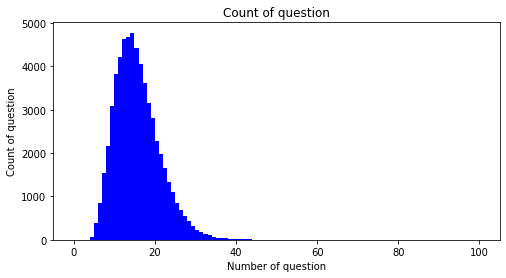

In [41]:
plt.figure(figsize=(8, 4))

plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
plt.title('Count of question')
plt.xlabel('Number of question')
plt.ylabel('Count of question')
plt.show()

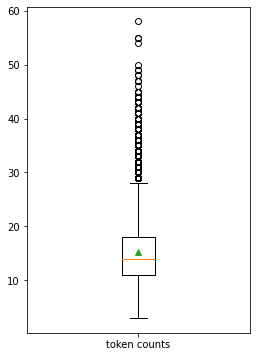

In [42]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

In [43]:
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")

percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


- 평균은 15.25에 최대 길이는 58입니다.

##### 2) Context

- 이번에는 context를 살펴봅니다.

In [44]:
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

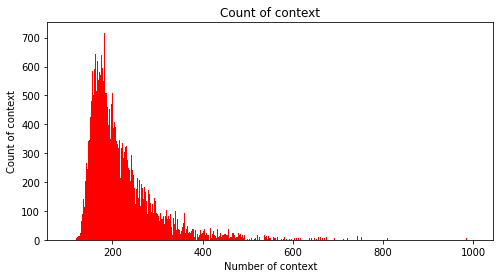

In [45]:
plt.figure(figsize=(8, 4))

plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

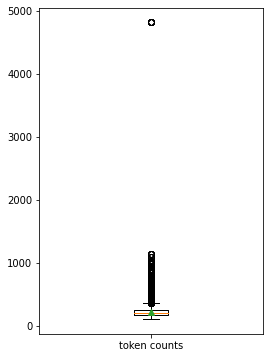

In [46]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

In [47]:
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")

percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


- 평균은 222.84에 최대 길이는 4816입니다.

##### 3) Answer

- 마지막으로 answer를 살펴봅니다.

In [48]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

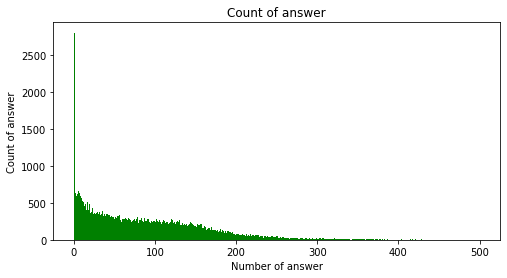

In [49]:
plt.figure(figsize=(8, 4))

plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

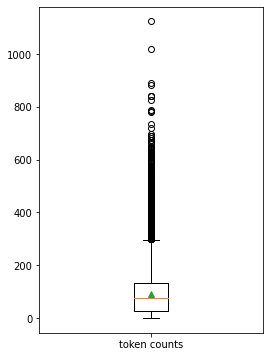

In [50]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

In [51]:
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")

percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


- answer의 위치에 대한 평균은 89.01에 최대는 1124입니다.  
1124면 엄청 멀리 위치하고 있습니다. 아마, 4816의 길이를 가진 context가 아닐까 추측해봅니다.

##### 4) Word Cloud

- 전체적인 word cloud를 확인하기 위해 documents에 title부터 context, question까지 넣어줍니다.

In [52]:
documents = []

for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

  0%|          | 0/1420 [00:00<?, ?it/s]

- wordcloud를 찍어봅니다.

In [53]:
wordcloud = WordCloud(width=800, height=800, font_path='/Library/Fonts/NanumSquareLight.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

OSError: ignored

#### 1.3.4 Dataset

- dataset을 구성할 준비를 합니다.

In [54]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [55]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

- 위에서 만든 load_data 함수를 통해 train_json, dev_json을 input과 label로 나눠줍니다.

In [56]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

### 1.4 Model

- BERT를 살펴보기 전에 Transformer를 먼저 봅니다.  
- transformer는 encoder와 decoder가 같이 붙은 구조입니다만, BERT는 transformer의 encoder 구조만 사용합니다.

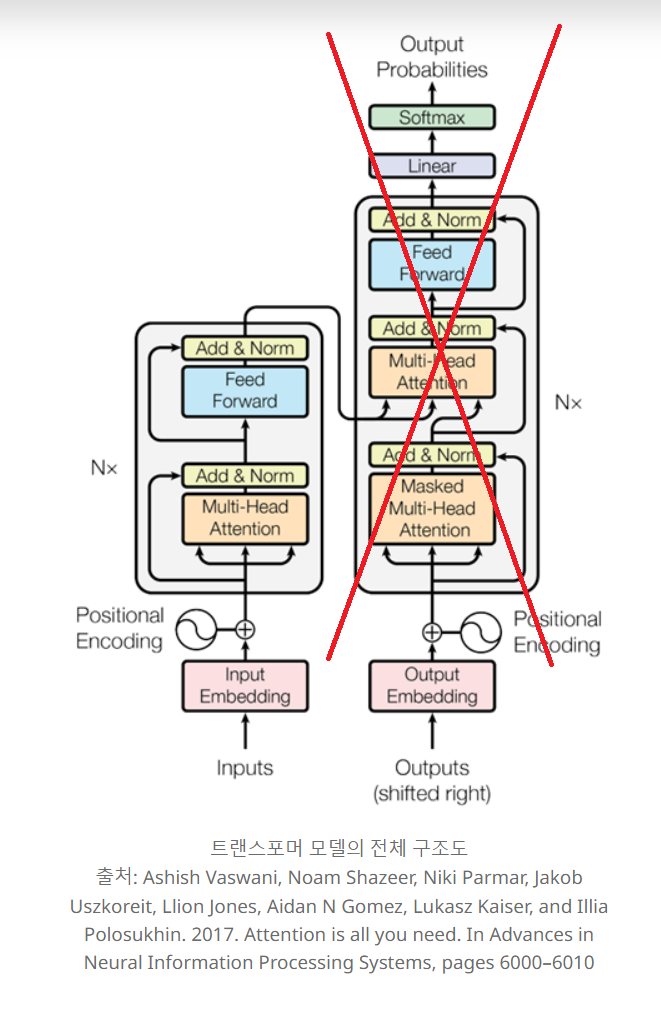

In [57]:
insert_img_1 = '/gdrive/My Drive/Colab Notebooks/QA/BERT_02.png'
insert_img_1 = cv2.imread(insert_img_1)
cv2_imshow(insert_img_1)

- BERT의 구조를 살펴봅니다.
- decoder가 없는 대신에 학습을 위해 MLM(Masked Language Model)과 NSP(Next Sentence Prediction)을 수행합니다.

- MLM(Masked Language Model)  
: 문장의 다음 단어를 예측하는게 아니고 문장의 랜덤 단어를 masking 처리하고 예측하는 방식으로 학습을 합니다.  
전체 단어를 다 수행하는 것이 아니고 전체의 약 15% 정도만 진행하고 모든 토큰을 masking하는 것이 아니고 80% 정도만 masking 처리하고 10%는 랜덤한 단어를, 나머지 10%는 정상적인 단어를 그대로 두는 방식을 활용합니다.

- NSP(Next Sentence Prediction)  
: 두 문장을 주고서 두 번째 문장이 첫 번째 문장의 뒤에 오는지 예측하는 방식으로 학습합니다.  
특히 QA와 NLI의 task에서 MLM으로만 학습하는 방식이 충분치 않아 NSP가 중요한 역할을 한다고 합니다.  
두 문장이 실제 이어지는 문장인지는 약 50%의 비율로 참, 거짓이 랜덤 추출이라고 합니다.

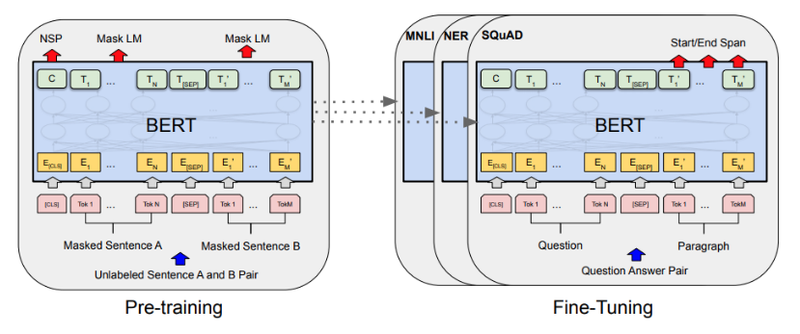

In [58]:
insert_img_2 = '/gdrive/My Drive/Colab Notebooks/QA/BERT.png'
insert_img_2 = cv2.imread(insert_img_2)
cv2_imshow(insert_img_2)

#### 1.4.1 Embedding

In [59]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

##### 2) Positional Embedding

In [60]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

#### 1.4.2 Encoder

##### 1) Scaled Dot Product Attention

In [61]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

##### 2) Multi Head Attention

In [62]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

##### 3) Feed Forward

In [63]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

##### 4) Encoder

In [64]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

#### 1.4.3 BERT

##### 1) BERT Layer

In [65]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [66]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

#### 1.4.4 Setting

##### 1) Config

- config를 통해 d_model, n_head, dropout 등의 값을 설정합니다.

In [67]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 512,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 8,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007}

##### 2) Dataset

- 위에서 나눈 train_inputs, train_labels, dev_inputs, dev_labels 파일을 dataset으로 만들어줍니다.

In [68]:
bert_batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

##### 3) model

In [69]:
model = BERT4KorQuAD(config)

##### 4) epoch

In [70]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [71]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

### 1.5 Training

#### 1.5.1 None_pretrained Model

- 이번에 돌릴 모델은 BERT의 모델 형태로, none_pretrained 입니다.  
차후 pretrained 모델과 비교해보려 합니다.

In [ ]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

history_1 = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    history_1['start_loss'].append(float(f'{start_loss:0.4f}'))
    history_1['end_loss'].append(float(f'{end_loss:0.4f}'))
    history_1['start_acc'].append(float(f'{start_acc:0.4f}'))
    history_1['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9133, 5.9134, acc: 0.0049, 0.0028
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9132, 5.9132, acc: 0.0053, 0.0051
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9148, 5.9148, acc: 0.0049, 0.0035


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9306, 5.9306, acc: 0.0028, 0.0032
early stopping


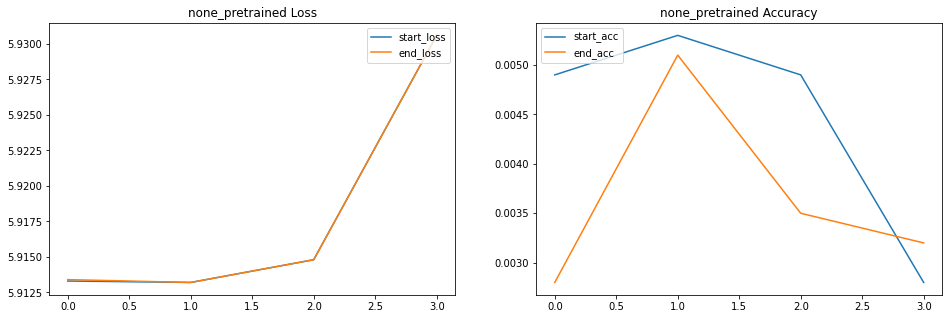

In [ ]:
epochs = range(len(history_1['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_1['start_loss'], label='start_loss')
plt.plot(epochs, history_1['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('none_pretrained Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history_1['start_acc'], label='start_acc')
plt.plot(epochs, history_1['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('none_pretrained Accuracy')

plt.show()

- 보기 안타까울 정도로 저조한 결과입니다.
- loss는 그래프가 하나처럼 보이지만 start_loss와 end_loss가 매우 비슷한 수치여서 그렇습니다.
- accuracy 값도 엉망이고, loss도 터무니없습니다.
- 하이퍼 파라미터를 수정하며 값을 낮춰볼 마음도 안 생길 정도입니다.

#### 1.5.2 Pretrained Model(Adam Optimizer)

- 이번에는 pretrained model을 사용합니다.  
- 6-layer, 512-hidden, 8-heads 형태로 large 모델보다 매우 작게 조절된 사이즈입니다.  
- pretrained model을 쓴다는 것 빼고는 모든 조건은 이전 none_pretrained와 동일합니다.

In [ ]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model_1 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model_2 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model_1(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model_1.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model_1.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_73 (Dense)            multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

history = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model_1, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model_1, dev_dataset, loss_fn, acc_fn)
    history['start_loss'].append(float(f'{start_loss:0.4f}'))
    history['end_loss'].append(float(f'{end_loss:0.4f}'))
    history['start_acc'].append(float(f'{start_acc:0.4f}'))
    history['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model_1.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.9638, 2.0755, acc: 0.5281, 0.5046
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6854, 1.9442, acc: 0.5616, 0.5219
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8149, 2.0748, acc: 0.5593, 0.5202


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.2071, 2.4727, acc: 0.5550, 0.5083
early stopping


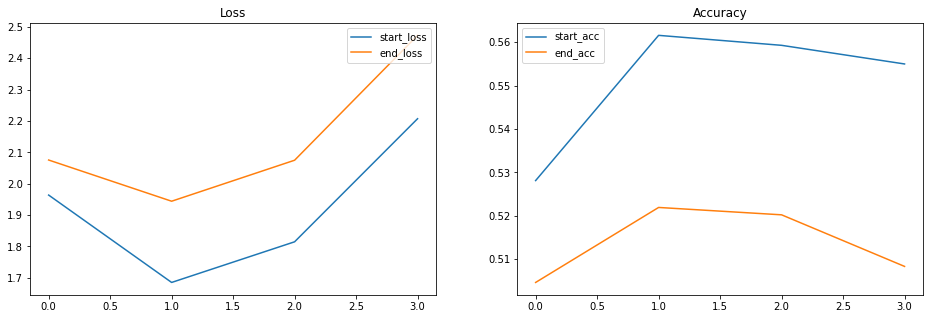

In [ ]:
epochs = range(len(history['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['start_loss'], label='start_loss')
plt.plot(epochs, history['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('model_1 Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history['start_acc'], label='start_acc')
plt.plot(epochs, history['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('model_1 Accuracy')

plt.show()

- 사실, early stopping 옵션으로 끝에 두 번의 acc 값은 best에 비해 낮아질 것입니다.
- 전체적으로 매우 양호한 수치라고 생각합니다.  
예측 결과를 빨리 보고 싶습니다.

#### 1.5.3 Pretrained Model(Radam Optimizer)

- 이번에는 pretrained model에 Radam optimizer를 적용합니다.

In [72]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model_2 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model_2 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model_2(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model_2.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model_2.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_73 (Dense)            multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [73]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer =  RAdam(total_steps=10, learning_rate=5e-4, warmup_proportion=0.1, min_lr=1e-5)

history_2 = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model_2, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model_2, dev_dataset, loss_fn, acc_fn)
    history_2['start_loss'].append(float(f'{start_loss:0.4f}'))
    history_2['end_loss'].append(float(f'{end_loss:0.4f}'))
    history_2['start_acc'].append(float(f'{start_acc:0.4f}'))
    history_2['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model_2.save_weights(os.path.join(data_dir, "korquad_bert_pretrain_2.hdf5"))
        print(f'save best model')
    else:
        patience += 1
        print(patience)
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 4.4932, 4.9120, acc: 0.0651, 0.0502
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 4.1831, 4.6004, acc: 0.0897, 0.0681
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 4.0311, 4.4944, acc: 0.1018, 0.0797
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 3.9730, 4.4113, acc: 0.1104, 0.0897
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 3.8443, 4.3495, acc: 0.1085, 0.0948
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 3.8408, 4.3472, acc: 0.1204, 0.0995
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 3.8411, 4.2891, acc: 0.1294, 0.1031
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 7 >> loss: 3.8150, 4.2639, acc: 0.1287, 0.1125
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 8 >> loss: 3.7687, 4.2490, acc: 0.1276, 0.1097
1


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 9 >> loss: 3.8318, 4.3492, acc: 0.1262, 0.1071
2
early stopping


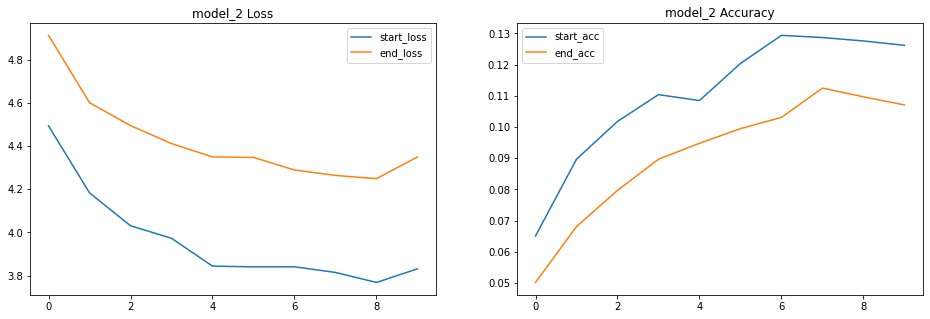

In [75]:
epochs = range(len(history_2['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_2['start_loss'], label='start_loss')
plt.plot(epochs, history_2['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('model_2 Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history_2['start_acc'], label='start_acc')
plt.plot(epochs, history_2['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('model_2 Accuracy')

plt.show()

- 매우 느리게 찾아가지만, epoch와 early stopping을 여유 있게 풀어주면 만족할 만한 값이 나올 것 같습니다.  
하지만 시간은 소중합니다...

#### 1.5.4 Pretrained Model(Nadam Optimizer)

- Adam에 NAG를 약간 변형하여 추가한 개념으로 Adam과는 다르게 momentum 방향으로 이동해서 gradient값을 다시 계산합니다.  
- Adam에 비해 global minia를 더 잘 찾아낼 수 있을거라는 기대감으로 사용해봅니다

In [88]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model_3 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model_2 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model_3(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model_3.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model_3.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_184 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


- Adam Optimizer와 동일한 비교를 위해 같은 learning_rate를 설정했습니다.

In [89]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

history_3 = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model_3, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model_3, dev_dataset, loss_fn, acc_fn)
    history_3['start_loss'].append(float(f'{start_loss:0.4f}'))
    history_3['end_loss'].append(float(f'{end_loss:0.4f}'))
    history_3['start_acc'].append(float(f'{start_acc:0.4f}'))
    history_3['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model_3.save_weights(os.path.join(data_dir, "korquad_bert_pretrain_3.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7289, 1.9388, acc: 0.5460, 0.5184
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.7543, 1.9591, acc: 0.5544, 0.5304
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8211, 2.0997, acc: 0.5678, 0.5233
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 1.9105, 2.1715, acc: 0.5688, 0.5314
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.1176, 2.4238, acc: 0.5442, 0.5130


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 2.5341, 2.8274, acc: 0.5397, 0.5060
early stopping


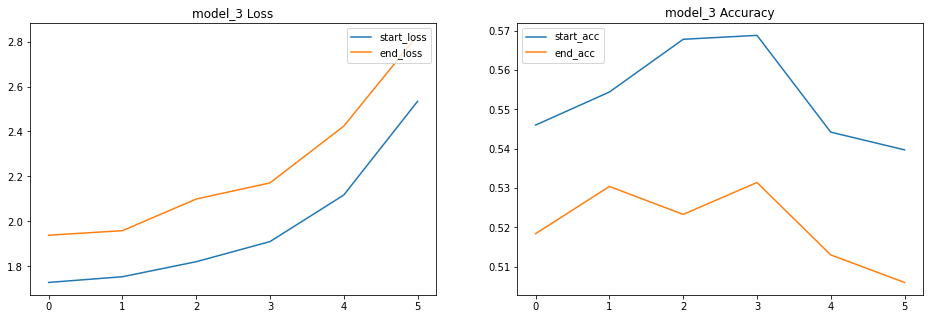

In [91]:
epochs = range(len(history_3['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_3['start_loss'], label='start_loss')
plt.plot(epochs, history_3['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('model_3 Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history_3['start_acc'], label='start_acc')
plt.plot(epochs, history_3['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('model_3 Accuracy')

plt.show()

- epoch 4회차에서 가장 높은 accuracy 값을 보여줍니다.   
(Nadam optimizer best acc: 0.5688, 0.5314)  
(Adam optimizer best acc: 0.5550, 0.5083)
- 약간의 향상이지만, 기분은 좋습니다.

#### 1.5.5 Pretrained Model(AdamW Optimizer)

- gradient에서 weight를 업데이트 할 때 Weight Decay로 일정 비율 감소시켜주는 방식을 포함한 optimizer입니다.

In [119]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model_4 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model_2 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model_4(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model_4.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model_4.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_332 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


- Adam Optimizer와 동일한 비교를 위해 같은 learning_rate를 설정했습니다.

In [121]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer =  tfa.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

history_4 = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model_4, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model_4, dev_dataset, loss_fn, acc_fn)
    history_4['start_loss'].append(float(f'{start_loss:0.4f}'))
    history_4['end_loss'].append(float(f'{end_loss:0.4f}'))
    history_4['start_acc'].append(float(f'{start_acc:0.4f}'))
    history_4['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model_4.save_weights(os.path.join(data_dir, "korquad_bert_pretrain_4.hdf5"))
        print(f'save best model')
    else:
        patience += 1
        print(patience)
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 4.1898, 4.7204, acc: 0.0720, 0.0451
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 4.4247, 4.9651, acc: 0.0641, 0.0414
1


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 4.3380, 4.8596, acc: 0.0723, 0.0432
2
early stopping


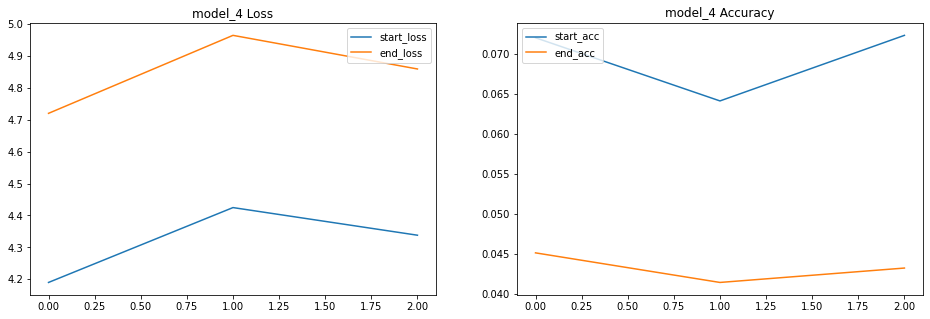

In [123]:
epochs = range(len(history_4['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_4['start_loss'], label='start_loss')
plt.plot(epochs, history_4['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('model_4 Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history_4['start_acc'], label='start_acc')
plt.plot(epochs, history_4['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('model_4 Accuracy')

plt.show()

- early stopping이 생각보다 짧은 경향이 있어서 아쉽지만, 시간 제약상 별 수 없었습니다.  
- 더 많은 epoch로 시도하면 지금보다는 좋은 결과를 얻을 것 같지만 그래도 기존 Adam 수준까지는 어려울 것 같습니다.  
- 시간은 소중합니다.

#### 1.5.6 Pretrained Model(RMSprop Optimizer)

- RMSprop을 개선할 아이디어를 반영한 것이 Adam이지만, 혹시나 하는 마음에서 한 번 시도해봅니다.

In [75]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model_5 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model_2 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model_5(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model_5.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model_5.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_147 (Dense)           multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [77]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer =  tf.keras.optimizers.RMSprop(learning_rate=5e-4, rho=0.9, epsilon=1e-07, decay=0.0)

history_5 = {'start_loss': [], 'end_loss': [], 'start_acc': [], 'end_acc': [] }
best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model_5, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model_5, dev_dataset, loss_fn, acc_fn)
    history_5['start_loss'].append(float(f'{start_loss:0.4f}'))
    history_5['end_loss'].append(float(f'{end_loss:0.4f}'))
    history_5['start_acc'].append(float(f'{start_acc:0.4f}'))
    history_5['end_acc'].append(float(f'{end_acc:0.4f}'))
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model_5.save_weights(os.path.join(data_dir, "korquad_bert_pretrain_5.hdf5"))
        print(f'save best model')
    else:
        patience += 1
        print(patience)
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 2.0800, 2.3007, acc: 0.5083, 0.4688
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.8566, 2.0074, acc: 0.5265, 0.4970
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.9618, 2.0359, acc: 0.5305, 0.5114
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.2594, 2.4312, acc: 0.4882, 0.4612
1


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.4343, 2.5377, acc: 0.4877, 0.4775
2
early stopping


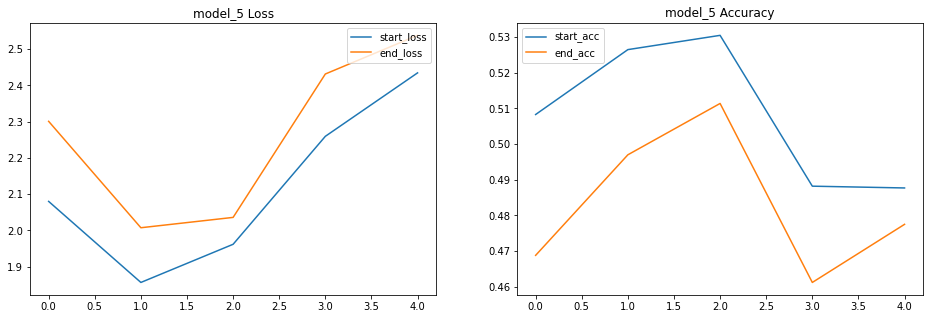

In [78]:
epochs = range(len(history_5['start_loss']))

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_5['start_loss'], label='start_loss')
plt.plot(epochs, history_5['end_loss'], label='end_loss')
plt.legend(loc='upper right')
plt.title('model_5 Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history_5['start_acc'], label='start_acc')
plt.plot(epochs, history_5['end_acc'], label='end_acc')
plt.legend(loc='upper left')
plt.title('model_5 Accuracy')

plt.show()

- RMSprop은 Adaptive Moment Estimation 계열이 아닌 optimizer로 결과 값이 준수해 놀랐습니다.   
RMSprop으로 early stopping을 널널하게 풀어주고 더 돌려보고 싶은 마음이 듭니다.

### 1.6 Visualization

- 지금까지 돌린 모델을 시각화하여 확인합니다.

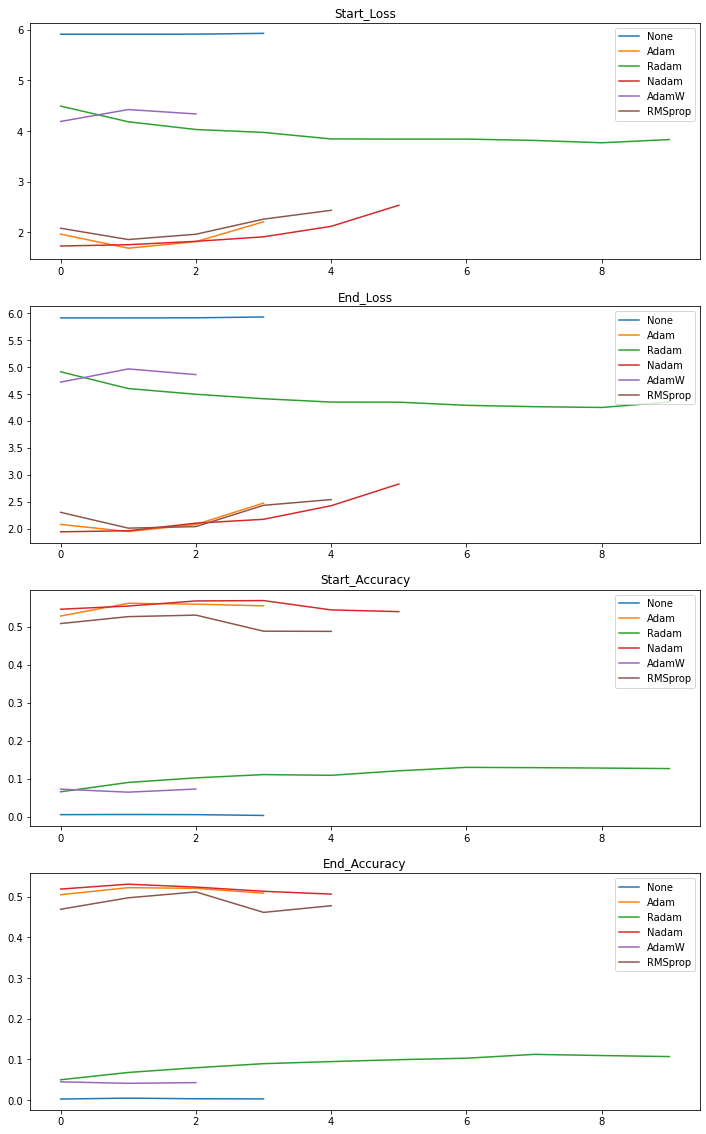

In [86]:
plt.figure(figsize=(12, 20))
plt.subplot(4, 1, 1)
plt.plot(history_1['start_loss'], label='None')
plt.plot(history['start_loss'], label='Adam')
plt.plot(history_2['start_loss'], label='Radam')
plt.plot(history_3['start_loss'], label='Nadam')
plt.plot(history_4['start_loss'], label='AdamW')
plt.plot(history_5['start_loss'], label='RMSprop')
plt.legend(loc='upper right')
plt.title('Start_Loss')

plt.subplot(4, 1, 2)
plt.plot(history_1['end_loss'], label='None')
plt.plot(history['end_loss'], label='Adam')
plt.plot(history_2['end_loss'], label='Radam')
plt.plot(history_3['end_loss'], label='Nadam')
plt.plot(history_4['end_loss'], label='AdamW')
plt.plot(history_5['end_loss'], label='RMSprop')
plt.legend(loc='upper right')
plt.title('End_Loss')

plt.subplot(4, 1, 3)
plt.plot(history_1['start_acc'], label='None')
plt.plot(history['start_acc'], label='Adam')
plt.plot(history_2['start_acc'], label='Radam')
plt.plot(history_3['start_acc'], label='Nadam')
plt.plot(history_4['start_acc'], label='AdamW')
plt.plot(history_5['start_acc'], label='RMSprop')
plt.legend(loc='upper right')
plt.title('Start_Accuracy')

plt.subplot(4, 1, 4)
plt.plot(history_1['end_acc'], label='None')
plt.plot(history['end_acc'], label='Adam')
plt.plot(history_2['end_acc'], label='Radam')
plt.plot(history_3['end_acc'], label='Nadam')
plt.plot(history_4['end_acc'], label='AdamW')
plt.plot(history_5['end_acc'], label='RMSprop')
plt.legend(loc='upper right')
plt.title('End_Accuracy')

plt.show()

- epoch 차이가 있어서 모양이 조금 기괴하지만, 이번 None_Pretrained 모델과 Pretrained 모델의 차이를 확인할 수 있습니다.  
- 특히, Nadam, Adam, RMSprop Optimizer 순으로 Loss, Accuracy 값이 준수하게 나왔습니다. 

### 1.7 Predict

#### 1.7.1 None_pretrained Model

- 몇 개만 살펴보겠습니다.

In [ ]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 20 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  지명수배 된 날은?[SEP] 1989년 2월 15일 여의도 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께

- 파국입니다... 평가할 부분이 없습니다.

#### 1.7.2 Pretrained Model(Adam Optimizer)

- 몇 개만 살펴보겠습니다.

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model_1, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 10 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

- 개인적으로 원래 정답보다 예측이 더 맘에 드는 경우도 있습니다.  
특히 7번에서 ~ 원로 헌법학자는? 이라는 질문에 '허영 경희대 석좌교수'라는 답변을 보면  
그냥 '허영'이라고 예측한 것보다 더 확실한 정보를 뽑은 느낌을 받았기 때문입니다.  
또, 10번 '~ 경희대 석좌교수 이름은?' 이라는 질문을 보면 정답인 '허영'만 정확히 뽑아냅니다.

- 다만 '임수경을'에서 _을 제거 못한 부분, '제89조'만 깔끔하게 뽑지 못한 부분은 매우 아쉽습니다.

## 2. Pipeline

- 비록 시간상 KorElectra model_large를 넘기지만 간단하게 pipeline을 통해 결과만 비교해보겠습니다.

### 2.1 Module

- 필요한 모듈을 설치합니다.

In [93]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [94]:
from transformers import ElectraTokenizer, ElectraForQuestionAnswering, pipeline

### 2.2 Model

- pretrained tokenizer와 model을 불러옵니다.
- Electra 모델 또한 Korquad data를 통해 학습한 것으로 알고 있습니다.

In [95]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v2-distilled-korquad-384")
model = ElectraForQuestionAnswering.from_pretrained("monologg/koelectra-small-v2-distilled-korquad-384")

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.3M [00:00<?, ?B/s]

### 2.3 Pipeline

- pipeline에 question과 context를 넣어 결과를 확인합니다.

In [96]:
qa = pipeline("question-answering", tokenizer=tokenizer, model=model)

In [125]:
print(qa({
    "question": "임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?",
    "context": "1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.",
}))

{'score': 0.9998310804367065, 'start': 0, 'end': 12, 'answer': '1989년 2월 15일'}


- 위 모델에서 사용한 context와 question을 넣었습니다.  
매우 정확하게 예측한 사례입니다.


In [126]:
print(qa({
    "question": "1989년 6월 30일 평양축전에 대표로 파견 된 인물은?",
    "context": "1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.",
}))

{'score': 0.9999077320098877, 'start': 125, 'end': 129, 'answer': '임수경을'}


- 이번에는 pretrained model과 같이 예측했습니다. _을 제거하지 못하는 모습을 보여줍니다.

In [128]:
print(qa({
    "question": "국무회의의 심의를 거쳐야 한다는 헌법 제 몇 조의 내용인가?",
    "context": '"내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10차 개헌안 발표이다. 원로 헌법학자인 허영 경희대 석좌교수는 정부의 헌법개정안 준비 과정에 대해 "청와대 비서실이 아닌 국무회의 중심으로 이뤄졌어야 했다"고 지적했다. 국무회의의 심의를 거쳐야 한다(제89조)는 헌법 규정에 충실하지 않았다는 것이다. 그러면서 "법무부 장관을 제쳐놓고 민정수석이 개정안을 설명하는 게 이해가 안 된다"고 지적했다. 민정수석은 국회의원에 대해 책임지는 법무부 장관도 아니고, 국민에 대해 책임지는 사람도 아니기 때문에 정당성이 없고, 단지 대통령의 신임이 있을 뿐이라는 것이다. 또한 국무총리 선출 방식에 대한 기자의 질문에 "문 대통령도 취임 전에 국무총리에게 실질적 권한을 주겠다고 했지만 그러지 못하고 있다. 대통령비서실장만도 못한 권한을 행사하고 있다."고 답변했다.'
}))

{'score': 0.9999706745147705, 'start': 187, 'end': 196, 'answer': '한다(제89조)는'}


- pretrained model은 같은 질문에 아래와 같이 예측했습니다.  
answer : '국무회의의 심의를 거쳐야 한다'(제89조)는  
pipeline으로 불러온 korelectra가 좀 더 깔끔한 것 같이 느껴집니다만, 둘다 결과는 아쉽습니다.  



## 3. Retrospect

##### 1) BERT
- BERT를 뜯어보는 것이 처음이라 이해하는데 어려움이 있었습니다.  
블로그 글을 보면서 정리했습니다. 정리한 내용중 3가지는 확실하게 이해하려고 노력했습니다.  
첫째, transformer의 decoder를 뺀 구조이다.  
둘째, MLM은 문장의 랜덤 단어를 마스킹처리하고 예측하여 학습한다.  
셋째, NSP는 두 문장의 순서를 예측하는 방법으로 학습한다.

##### 2) Learning rate
- Optimizer를 적용할 때 적절한 Learning_rate 값을 찾는 것이 매우 중요했습니다.  
여기서는 따로 결과를 남기지 않았습니다만, 초기 learning_rate 값에 따라 여러번 모델을 돌렸습니다.  
현재 5e-4를 defualt로 주고 있지만, 이보다 높은 값은 결과가 좋지 못했습니다.  
(1e-3에서는 쉽게 loss가 4~5 수준, acc는 0.02 수준을 보였습니다.)  
특히 더 높은 값에서는 발산하는 모습도 확인했습니다.

##### 3) Optimizer
- 여러 Optimizer를 찾으며 공부하는 부분이 재미있습니다.  
googling을 하다 보면 다들 무조건 Adam을 외치는데 실제 다른 Optimizer를 써보면 꼭 그런 것도 아닌 것 같습니다.  
Adam이 RMSprop의 개선된 버전이라고 알고 있는데 때에 따라선 RMSProp이 더 빠르게 loss를 줄이고 acc를 높이는 경우도 있습니다.  
또, Adam이 너무 빠르게 local optima에 도달하는 문제를 개선하기 위해 나온 Rectified Adam도 흥미로웠습니다.  
그리고 이번에 install은 했지만, 사용하지 못한 AdamP가 아쉬워서 다음에 한 번 더 돌릴 생각입니다.

##### 4) Large Model
- 이번에는 시간상 Pretrained Model의 가장 작은 형태를 사용했습니다.  
분명 더 많은 데이터로 학습된 모델을 사용하면 더 좋은 성능을 낼 수 있을 텐데 라는 생각에 좀 아쉬웠습니다.  
특히, 같은 KorQuaD 데이터 기준 KoELECTRA-Base-v2의 score가 상당합니다.  
이런 모델의 large 버전을 써보고 싶습니다.
https://github.com/Beomi/KcBERT <--- 이곳에서 확인해 볼 수 있습니다.

##### 5) Colab Runtime
- 매번 느끼는 건데 돈 주고 사용하는 colab pro의 runtime 연결 해제에 분노합니다.  
runtime 연결을 일정 시간 동안 보장만 해줘도 좋겠습니다.  
epoch 1회에 약 15분가량 걸리는 모델을 3~4개씩 돌리는데 중간에 끊기는 게 한두 번이 아닙니다.  
model save 기능을 활용하고 있지만 매번 불안합니다.

## 4. References

- 아래의 사이트에서 큰 도움을 받았습니다.

##### 1) BERT
 - https://docs.likejazz.com/bert/
 - https://hryang06.github.io/nlp/BERT/#1-token-embeddings
 - https://mino-park7.github.io/nlp/2018/12/12/bert-%EB%85%BC%EB%AC%B8%EC%A0%95%EB%A6%AC/?fbclid=IwAR3S-8iLWEVG6FGUVxoYdwQyA-zG0GpOUzVEsFBd0ARFg4eFXqCyGLznu7w

##### 2) KorQuad
- https://korquad.github.io/
- https://github.com/graykode/KorQuAD-beginner

##### 3) Optimizer
 - https://pypi.org/project/keras-radam/
 - https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW
 - https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/RectifiedAdam
 - https://keras.io/api/optimizers/Nadam/
 - https://blog.naver.com/j767asde/222161436206
 - https://zzaebok.github.io/deep_learning/RAdam/
 - https://wikidocs.net/157281
 - https://jonhyuk0922.tistory.com/162
 

##### 4) Preprocess
 - https://ebbnflow.tistory.com/246

##### 5) SentencePiece
 - https://github.com/google/sentencepiece
 - https://arxiv.org/pdf/1808.06226.pdf

